In [71]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

import pandas as pd

# Pre-defined functions

In [176]:
def plot_gp(mu, cov, X, X_train=None, Y_train=None, samples=[]):
    X = X.ravel()
    mu = mu.ravel()
    uncertainty = 1.96 * np.sqrt(np.diag(cov))
    
    plt.fill_between(X, mu + uncertainty, mu - uncertainty, alpha=0.1)
    plt.plot(X, mu, label='Mean')
    for i, sample in enumerate(samples):
        plt.plot(X, sample, lw=1, ls='--', alpha=0.3) #, label=f'Sample {i+1}'
    if X_train is not None:
        plt.plot(X_train, Y_train, 'rx')
    plt.legend()


def kernel(X1, X2, l=1.0, sigma_f=1.0):
    '''
    Args:
        X1: Array of m points (m x d).
        X2: Array of n points (n x d).

    Returns:
        Covariance matrix (m x n).
    '''
    sqdist = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
    return sigma_f**2 * np.exp(-0.5 / l**2 * sqdist)

from numpy.linalg import inv

def posterior_predictive(X_s, X_train, Y_train, l=1.0, sigma_f=1.0, sigma_y=1e-8):
    '''
    Computes the suffifient statistics of the GP posterior predictive distribution 
    from m training data X_train and Y_train and n new inputs X_s.
    
    Args:
        X_s: New input locations (n x d).
        X_train: Training locations (m x d).
        Y_train: Training targets (m x 1).
        l: Kernel length parameter.
        sigma_f: Kernel vertical variation parameter.
        sigma_y: Noise parameter.
    
    Returns:
        Posterior mean vector (n x d) and covariance matrix (n x n).
    '''
    K = kernel(X_train, X_train, l, sigma_f) + sigma_y**2 * np.eye(len(X_train))
    K_s = kernel(X_train, X_s, l, sigma_f)
    K_ss = kernel(X_s, X_s, l, sigma_f) + 1e-8 * np.eye(len(X_s))
    K_inv = inv(K)
    
    mu_s = K_s.T.dot(K_inv).dot(Y_train)

    cov_s = K_ss - K_s.T.dot(K_inv).dot(K_s)
    
    return mu_s, cov_s

# Data generation

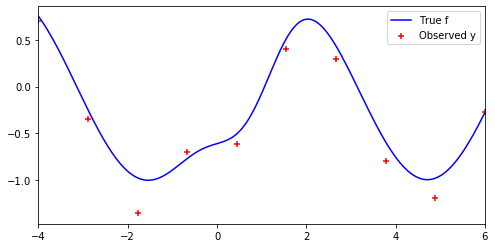

In [424]:
lb,ub = -4,6
bounds = np.array([[lb, ub]])
x = np.linspace(lb, ub, 10).reshape(-1,1)
noise=0.2

X_new = np.arange(bounds[:, 0], bounds[:, 1], 0.01).reshape(-1, 1)


def f1(x, noise=1):
    y = -np.exp(-(x - .7)**2) + np.sin(x) + np.random.randn(*x.shape) * noise #ex2
    #x**3*np.sin(x) -x**2 + 2*x + np.random.randn(*x.shape) * noise #ex1
    return y

y = f1(x,noise=noise)
true_f = f1(X_new, noise=0)
plt.figure(figsize=(8, 4))
plt.xlim(lb, ub)
plt.scatter(x, y, marker='+', c='r', label='Observed y')
plt.plot(X_new, true_f, 'b', label='True f')
plt.legend(loc='best')
plt.show()

# Using maximum likelihood estimation to find the optimal parameter values

Optimal values for these parameters can be estimated by maximizing the log marginal likelihood which is given by<sup>[1][3]</sup>

$$
\log p(\mathbf{y} \lvert \mathbf{X}) = 
\log \mathcal{N}(\mathbf{y} \lvert \boldsymbol{0},\mathbf{K}_y) =
-\frac{1}{2} \mathbf{y}^T \mathbf{K}_y^{-1} \mathbf{y} 
-\frac{1}{2} \log \begin{vmatrix}\mathbf{K}_y\end{vmatrix} 
-\frac{N}{2} \log(2\pi) \tag{7}
$$

In the following we will minimize the negative log marginal likelihood w.r.t. parameters $l$, $\sigma_f$ and $\sigma_y$. 


In [282]:
from numpy.linalg import cholesky, det, lstsq
from scipy.optimize import minimize

def nll_fn(X_train, Y_train):
    '''
    Returns a function that computes the negative log marginal
    likelihood for training data X_train and Y_train (noise is unknown)
    
    Args:
        X_train: training locations (m x d).
        Y_train: training targets (m x 1).
        
    Returns:
        Minimization objective.
    '''

    def nll_stable(theta):
        # Numerically more stable implementation of Eq. (7) as described
        # in http://www.gaussianprocess.org/gpml/chapters/RW2.pdf, Section
        # 2.2, Algorithm 2.1.
        K = kernel(X_train, X_train, l=theta[0], sigma_f=theta[1]) + \
            theta[2]**2 * np.eye(len(X_train))
        L = cholesky(K)
        return np.sum(np.log(np.diagonal(L))) + \
               0.5 * Y_train.T.dot(lstsq(L.T, lstsq(L, Y_train)[0])[0]) + \
               0.5 * len(X_train) * np.log(2*np.pi)
    
    return nll_stable

In [421]:
# Minimize the negative log-likelihood w.r.t. parameters l, sigma_f and sigma_y
n_restarts = 25
dim = 3
min_val = 10000
min_x = None

for x0 in np.random.uniform(0, 1, size=(n_restarts, dim)):
    res = minimize(nll_fn(x, y), x0=x0, bounds=((1e-5, None), (1e-5, None),(1e-5, None)), method='L-BFGS-B')        
    if res.fun < min_val:
        min_val = res.fun[0]
        min_x = res.x 
        
l_opt, sigma_f_opt, sigma_y_opt = min_x
l_opt, sigma_f_opt, sigma_y_opt


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


(1.3190690780723726, 0.7284501601957917, 0.07984663092970107)

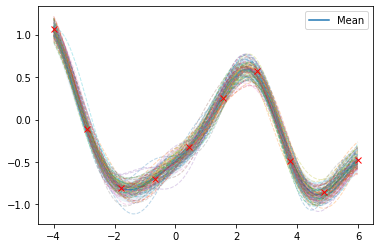

In [422]:
# Compute the prosterior predictive statistics with optimized kernel parameters and plot the results
n_sample = 100
mu_s, cov_s = posterior_predictive(X_new, x, y, l=l_opt, sigma_f=sigma_f_opt, sigma_y=sigma_y_opt)
samples = np.random.multivariate_normal(mu_s.ravel(), cov_s, n_sample)
plot_gp(mu_s, cov_s, X_new, X_train=x, Y_train=y, samples=samples)

# Find the location where global minimum of $f(x)|Y$ is obtained

Each sample of posterior predictive distribution is a sample of $f(x)|Y$. By finding the minimum point of multiple posterior predictive distribution samples, we can obtain the empirical distribution of arg min $f(x)|Y$.

We regard each sampled posterior predictive distribution as noise-free objective.

In [289]:
def sampled_pp(x,noise=noise):
    """
    returns the output of the sampled posterior predictive distribution
    """
    Y_ = []
    for i in range(len(X_new)):
        if round(X_new[i][0],1) == round(x[0][0],1):
            Y_.append(f[i])
    Y_ = np.array([[np.mean(Y_)]]) + noise * np.random.randn(*x.shape)
    return Y_

In [423]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, Matern

locations = np.array([[]])

for i in range(n_sample):
    f = samples[i]
    X_init = np.array([[-1.6], [3.7]])
    Y_init = initial_Y(X_init)
    
    # Gaussian process with Mat??rn kernel as surrogate model
    m52 = ConstantKernel(1.0) * Matern(length_scale=1.0, nu=2.5)
    gpr = GaussianProcessRegressor(kernel=m52, alpha=noise**2)

    # Initialize samples
    X_sample = X_init
    Y_sample = Y_init

    # Number of iterations
    n_iter = 20

    opt_val = Y_init[0]
    opt_loc = X_init[0] # store optimal location

    for i in range(n_iter):
        # Update Gaussian process with existing samples
        gpr.fit(X_sample, Y_sample)

        # Obtain next sampling point from the acquisition function (expected_improvement)
        X_next = propose_location(expected_improvement, X_sample, Y_sample, gpr, bounds)
    
        # Obtain next noisy sample from the objective function
        Y_next = sampled_pp(X_next,noise=sigma_y_opt)
    
        if Y_next < opt_val:
            opt_val = Y_next
            opt_loc = X_next
    
        # Add sample to previous samples
        X_sample = np.vstack((X_sample, X_next))
        Y_sample = np.vstack((Y_sample, Y_next))
    
    
    locations = np.append(locations,opt_loc)

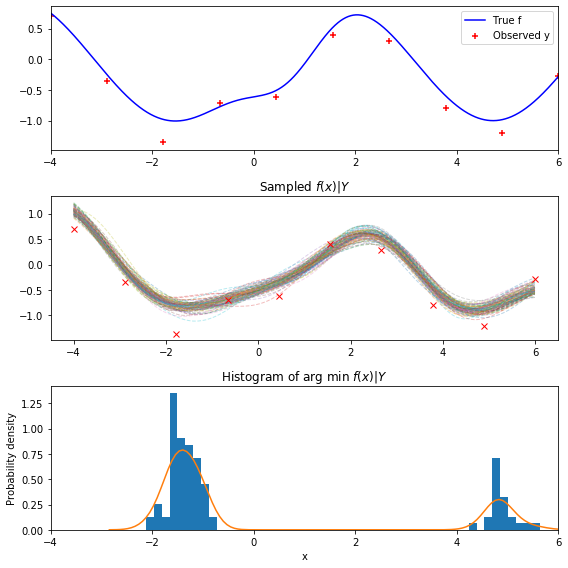

In [425]:
import scipy.stats as sts
num_bins = 50

fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(8,8))

ax1.set_xlim(lb, ub)
ax1.scatter(x, y, marker='+', c='r', label='Observed y')
ax1.plot(X_new, true_f, 'b', label='True f')
ax1.legend(loc='best')

X = X_new.ravel()
for i, sample in enumerate(samples):
    ax2.plot(X, sample, lw=1, ls='--', alpha=0.3) 
if x is not None:
    ax2.plot(x, y, 'rx')
ax2.set_title(r'Sampled $f(x)|Y$')

# the histogram of the data
n, bins, patches = ax3.hist(locations, num_bins, density=1)
sns.distplot(locations,ax=ax3,hist=False)
ax3.set_xlim(lb, ub)
ax3.set_xlabel('x')
ax3.set_ylabel('Probability density')
ax3.set_title(r'Histogram of arg min $f(x)|Y$')

fig.tight_layout()
plt.savefig('opt_2.png')
plt.show()

In [178]:
f = samples[0]
X_init = np.array([[-1.6], [3.7]])

def initial_Y(X_init):
    """
    returns initial values of Y
    """
    Y1_init = []
    for i in range(len(X_new)):
        if round(X_new[i][0],1) == X_init[0][0]:
            Y1_init.append(samples[0][i])


    Y2_init = []
    for i in range(len(X_new)):
        if round(X_new[i][0],1) == X_init[1][0]:
            Y2_init.append(samples[0][i])

    Y_init = np.array([[np.mean(Y1_init)],[np.mean(Y2_init)]]) + noise * np.random.randn(*X_init.shape)
    return Y_init

Y_init = initial_Y(X_init)

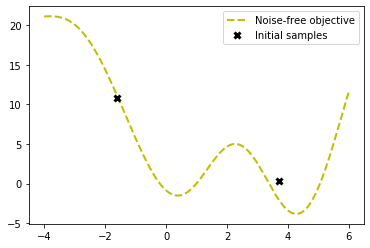

In [179]:
# Plot optimization objective with noise level 
plt.plot(X_new, f, 'y--', lw=2, label='Noise-free objective')
plt.plot(X_init, Y_init, 'kx', mew=3, label='Initial samples')
plt.legend()
plt.show()

In [129]:
from scipy.stats import norm

def expected_improvement(X, X_sample, Y_sample, gpr, xi=0.01):
    '''
    Computes the EI at points X based on existing samples X_sample
    and Y_sample using a Gaussian process surrogate model.
    
    Args:
        X: Points at which EI shall be computed (m x d).
        X_sample: Sample locations (n x d).
        Y_sample: Sample values (n x 1).
        gpr: A GaussianProcessRegressor fitted to samples.
        xi: Exploitation-exploration trade-off parameter.
    
    Returns:
        Expected improvements at points X.
    '''
    mu, sigma = gpr.predict(X, return_std=True)
    mu_sample = gpr.predict(X_sample)

    sigma = sigma.reshape(-1, 1)
    
    # Needed for noise-based model,
    # otherwise use np.max(Y_sample).
    mu_sample_opt = np.min(mu_sample) # minimization
    #mu_sample_opt = np.min(Y_sample) # minimization

    with np.errstate(divide='warn'):
        imp = - mu + mu_sample_opt - xi # minimization
        Z = imp / sigma
        ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
        ei[sigma == 0.0] = 0.0

    return ei

In [114]:
from scipy.optimize import minimize

def propose_location(acquisition, X_sample, Y_sample, gpr, bounds, n_restarts=25):
    '''
    Proposes the next sampling point by optimizing the acquisition function.
    
    Args:
        acquisition: Acquisition function.
        X_sample: Sample locations (n x d).
        Y_sample: Sample values (n x 1).
        gpr: A GaussianProcessRegressor fitted to samples.

    Returns:
        Location of the acquisition function maximum.
    '''
    dim = X_sample.shape[1]
    min_val = 1
    min_x = None
    
    def min_obj(X):
        # Minimization objective is the negative acquisition function
        return -acquisition(X.reshape(-1, dim), X_sample, Y_sample, gpr)
    
    # Find the best optimum by starting from n_restart different random points.
    for x0 in np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_restarts, dim)):
        res = minimize(min_obj, x0=x0, bounds=bounds, method='L-BFGS-B')        
        if res.fun < min_val:
            min_val = res.fun[0]
            min_x = res.x           
            
    return min_x.reshape(-1, 1)

In [115]:
def plot_approximation(gpr, X, Y, X_sample, Y_sample, X_next=None, show_legend=False):
    mu, std = gpr.predict(X, return_std=True)
    plt.fill_between(X.ravel(), 
                     mu.ravel() + 1.96 * std, 
                     mu.ravel() - 1.96 * std, 
                     alpha=0.1) 
    plt.plot(X, Y, 'y--', lw=1, label='Noise-free objective')
    plt.plot(X, mu, 'b-', lw=1, label='Surrogate function')
    plt.plot(X_sample, Y_sample, 'kx', mew=3, label='Noisy samples')
    if X_next:
        plt.axvline(x=X_next, ls='--', c='k', lw=1)
    if show_legend:
        plt.legend()

def plot_acquisition(X, Y, X_next, show_legend=False):
    plt.plot(X, Y, 'r-', lw=1, label='Acquisition function')
    plt.axvline(x=X_next, ls='--', c='k', lw=1, label='Next sampling location')
    if show_legend:
        plt.legend()

[[-5.85732715]]
[[4.18679896]]


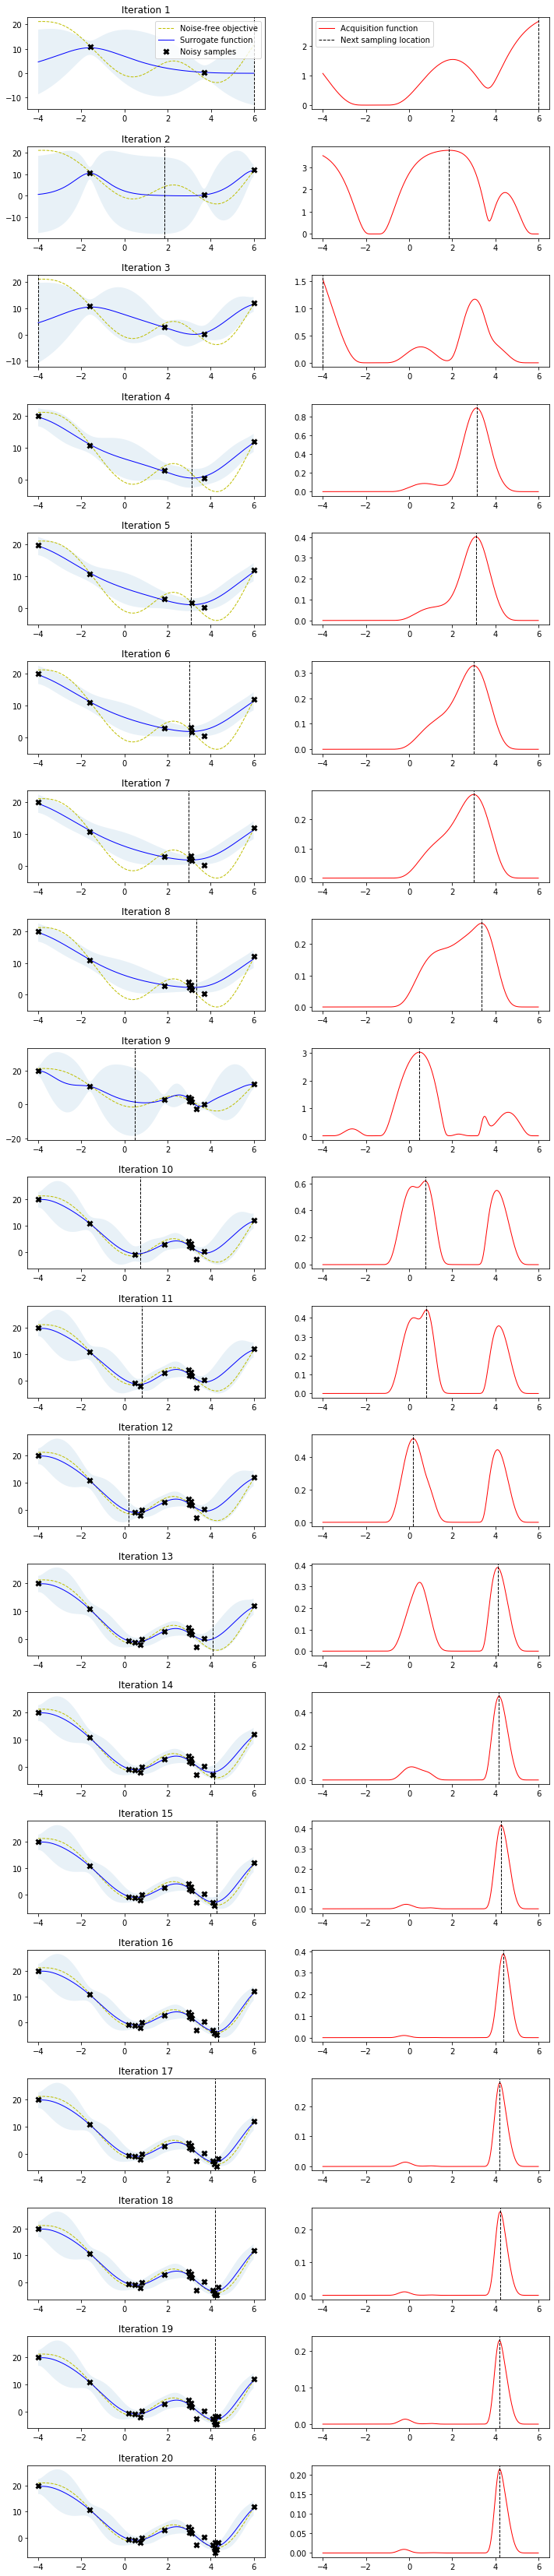

In [180]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, Matern

# Gaussian process with Mat??rn kernel as surrogate model
m52 = ConstantKernel(1.0) * Matern(length_scale=1.0, nu=2.5)
gpr = GaussianProcessRegressor(kernel=m52, alpha=noise**2)

# Initialize samples
X_sample = X_init
Y_sample = Y_init

# Number of iterations
n_iter = 20

plt.figure(figsize=(12, n_iter * 3))
plt.subplots_adjust(hspace=0.4)

opt_val = Y_init[0]
opt_loc = X_init[0] # store optimal location

for i in range(n_iter):
    # Update Gaussian process with existing samples
    gpr.fit(X_sample, Y_sample)

    # Obtain next sampling point from the acquisition function (expected_improvement)
    X_next = propose_location(expected_improvement, X_sample, Y_sample, gpr, bounds)
    
    # Obtain next noisy sample from the objective function
    Y_next = sampled_pp(X_next)
    
    if Y_next < opt_val:
        opt_val = Y_next
        opt_loc = X_next
    
    # Plot samples, surrogate function, noise-free objective and next sampling location
    plt.subplot(n_iter, 2, 2 * i + 1)
    plot_approximation(gpr, X_new, f, X_sample, Y_sample, X_next, show_legend=i==0)
    plt.title(f'Iteration {i+1}')

    plt.subplot(n_iter, 2, 2 * i + 2)
    plot_acquisition(X_new, expected_improvement(X_new, X_sample, Y_sample, gpr), X_next, show_legend=i==0)
    
    # Add sample to previous samples
    X_sample = np.vstack((X_sample, X_next))
    Y_sample = np.vstack((Y_sample, Y_next))
    
    
print(opt_val)
print(opt_loc)